# EVALUATE MODEL TEST SET

classification report

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

DESC = 'resnet'
LABELS_MAP = ['0-No DR', '1-Mild', '2-Moderate', '3-Severe', '4-Proliferative DR']
NUM_CLASSES = len(LABELS_MAP)

y_true = np.load(f'../results/{DESC}/test_results.npz')['y_true']
y_logits = np.load(f'../results/{DESC}/test_results.npz')['y_logit']
y_pred = np.load(f'../results/{DESC}/test_results.npz')['y_pred']

print(classification_report(y_true, y_pred, labels=range(NUM_CLASSES), target_names=LABELS_MAP, zero_division=0))

                    precision    recall  f1-score   support

           0-No DR       0.78      0.97      0.86      5162
            1-Mild       0.00      0.00      0.00       489
        2-Moderate       0.43      0.21      0.28      1059
          3-Severe       0.41      0.07      0.12       175
4-Proliferative DR       0.47      0.19      0.27       141

          accuracy                           0.75      7026
         macro avg       0.42      0.29      0.31      7026
      weighted avg       0.66      0.75      0.69      7026



confusion matrix

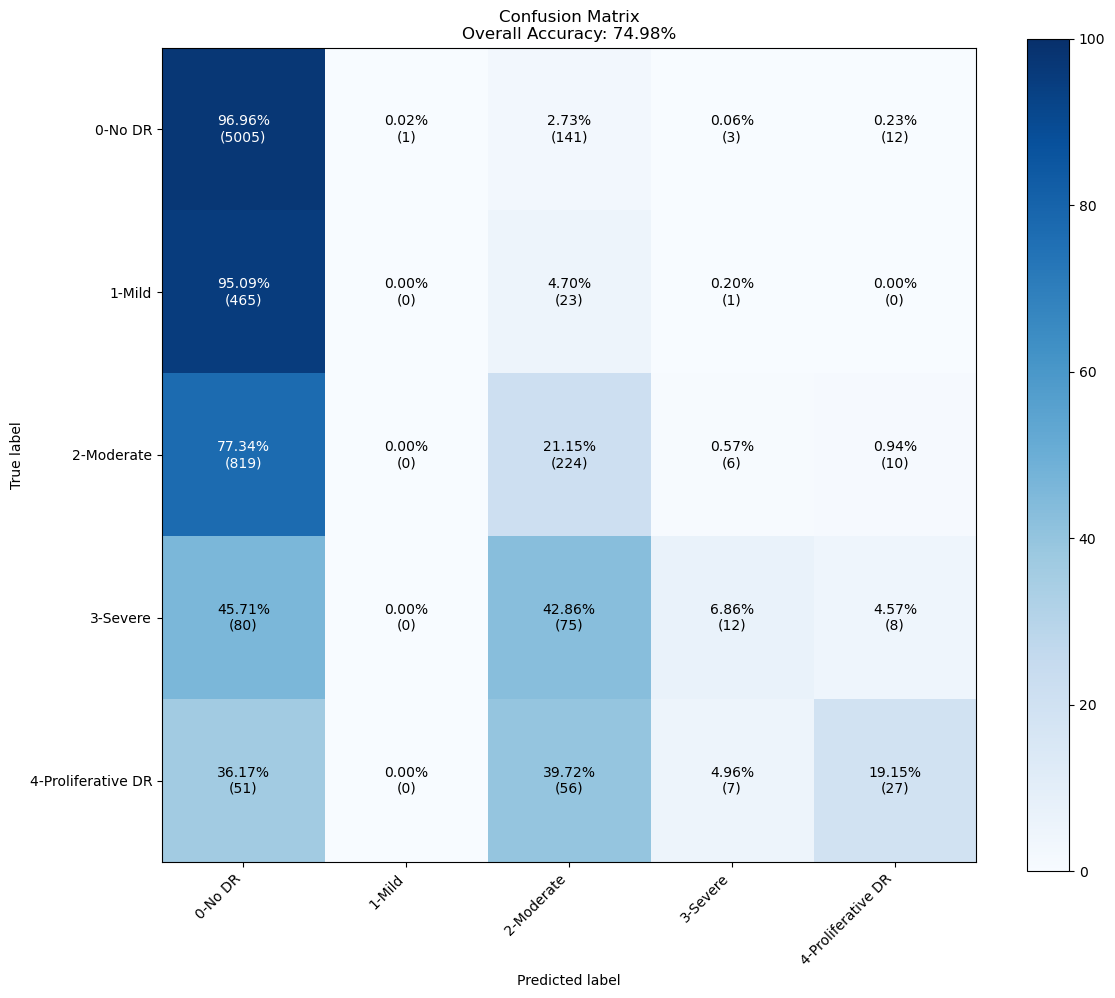

In [2]:
# compute
cm_counts = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
cm_percent = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
cm_percent = np.round(cm_percent, 2)

# plot
plt.figure(figsize=(12, 10))
plt.imshow(cm_percent, cmap='Blues')
plt.title(f'Confusion Matrix\nOverall Accuracy: {100*(np.sum(y_true == y_pred)/len(y_true)):.2f}%')
plt.xticks(np.arange(NUM_CLASSES), LABELS_MAP, rotation=45, ha='right')
plt.yticks(np.arange(NUM_CLASSES), LABELS_MAP)
plt.colorbar()
plt.clim(0, 100)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# add %/counts
thresh = cm_percent.max() / 2.
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        percent = cm_percent[i, j]
        count = cm_counts[i, j]
        plt.text(j, i, f'{percent:.2f}%\n({count})', ha='center', va='center',
                color='white' if percent > thresh else 'black')

plt.tight_layout()
plt.show()

# # old method, no counts
# cm = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_MAP)
# # plot on large figure
# fig, ax = plt.subplots(figsize=(20,20))
# disp.plot(xticks_rotation = 45, values_format = '.2f', ax=ax, cmap='Blues')
# plt.title('Confusion Matrix')
# plt.tight_layout()
# plt.show()

roc curves

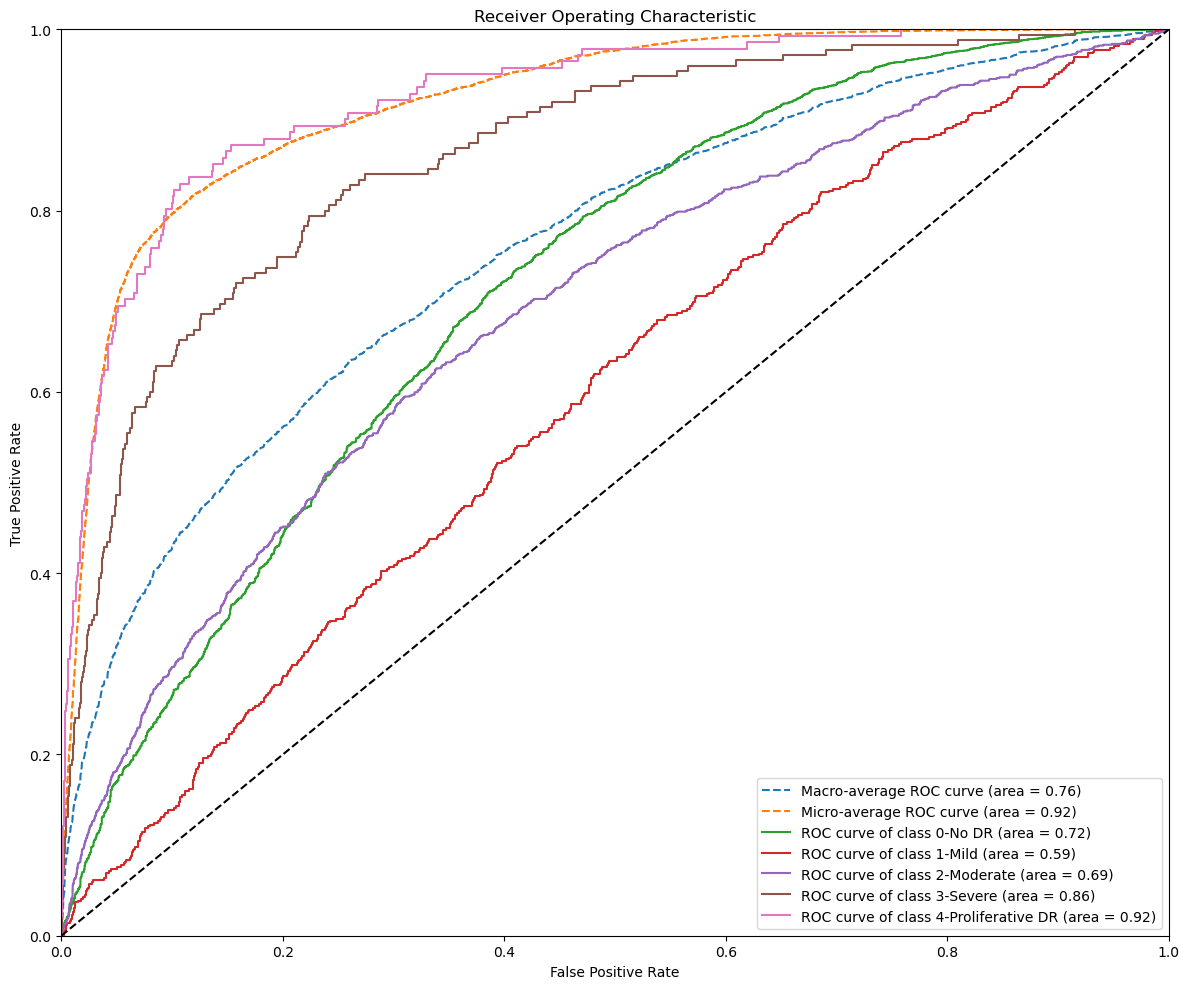

In [3]:
# one vs all roc curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# onehot encode labels
y_true_onehot = label_binarize(y_true, classes=range(NUM_CLASSES))

# roc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# macro/micro average
# macro
fpr['macro'] = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
tpr['macro'] = np.zeros_like(fpr['macro'])
for i in range(NUM_CLASSES):
    tpr['macro'] += np.interp(fpr['macro'], fpr[i], tpr[i])
tpr['macro'] /= NUM_CLASSES
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

# micro
fpr['micro'], tpr['micro'], _ = roc_curve(y_true_onehot.ravel(), y_logits.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# plot ROC curves
plt.figure(figsize=(12, 10))
plt.plot(fpr['macro'], tpr['macro'], label=f'Macro-average ROC curve (area = {roc_auc['macro']:.2f})', linestyle='--')
plt.plot(fpr['micro'], tpr['micro'], label=f'Micro-average ROC curve (area = {roc_auc['micro']:.2f})', linestyle='--')
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {LABELS_MAP[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.tight_layout()
plt.show()

# OLD: load datasets and get model predicitions

In [4]:
# # load trained model/datasets

# import torch
# import numpy as np
# import pandas as pd

# DESC = 'resnet'
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# trained_model = torch.load(f'../results/{DESC}/model.pth', weights_only=False).to(DEVICE)
# metadata = torch.load(f'../results/{DESC}/metadata.pth', weights_only=False)
# print(metadata.keys())

# labels = pd.read_csv('../data/trainLabels.csv')
# NUM_CLASSES = len(labels['level'].unique())
# LABELS_MAP = ['0-No DR', '1-Mild', '2-Moderate', '3-Severe', '4-Proliferative DR']
# BATCH_SIZE = 32

# test_data = metadata['test_data']
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# trained_model.eval()
# y_true = []
# y_logit = []
# y_pred = []
# with torch.no_grad():
#     for i, (inputs, labels) in enumerate(test_loader):
#         inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
#         outputs = trained_model(inputs)
#         y_true.extend(labels.cpu().numpy())
#         y_logit.extend(outputs.cpu().numpy())
#         y_pred.extend(torch.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy())

# y_true = np.array(y_true)
# y_logit = np.array(y_logit)
# y_pred = np.array(y_pred)
# np.savez(f'../results/{DESC}/test_results.npz', y_true=y_true, y_logit=y_logit, y_pred=y_pred)